# Project: Video Game Use Analysis 
(code and viz only)

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(janitor)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
sessions <- read_csv('sessions.csv') |> 
    clean_names() |>
    select(start_time) |>
    separate(start_time, into = c('start_date', 'start_time'), sep = ' ') |>
    separate(start_time, c('start_hour', 'start_min'), ':')

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
sessions_hour <- sessions |>
    select(start_hour) |>
    map_df(as.numeric)

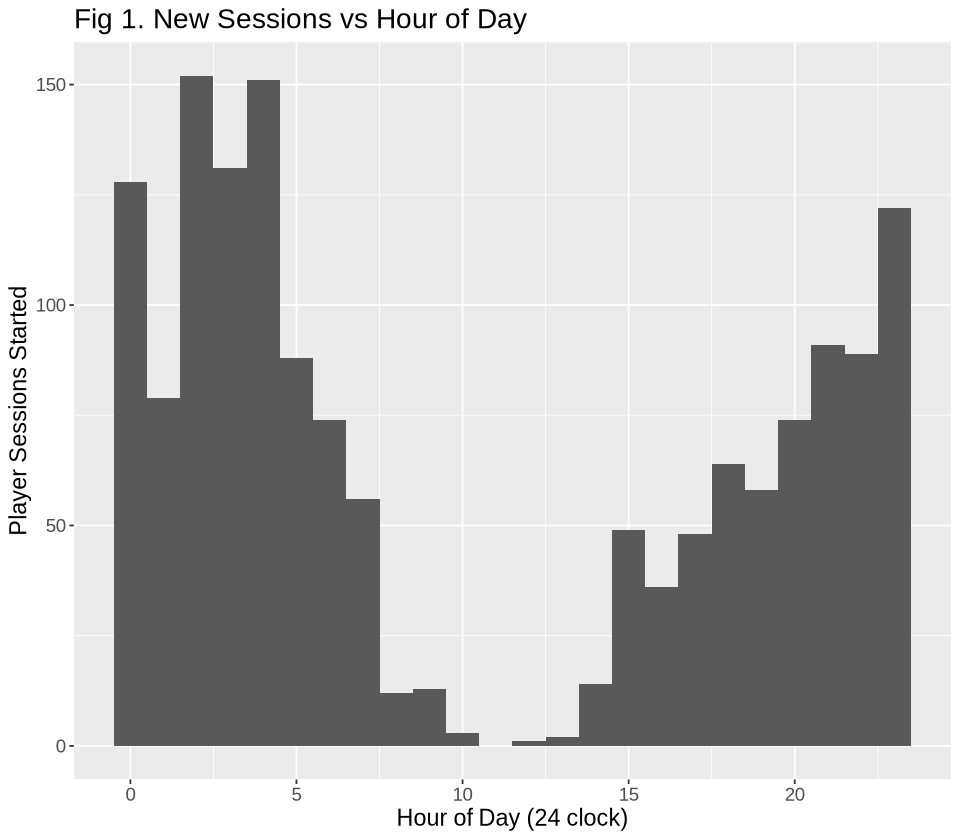

In [4]:
options(repr.plot.width = 8, repr.plot.height = 7)

new_sessions_plot <- sessions_hour |>
    ggplot(aes(x = start_hour)) + 
    geom_histogram(binwidth = 1) + 
    labs(x = 'Hour of Day (24 clock)', y = 'Player Sessions Started', title = 'Fig 1. New Sessions vs Hour of Day') + 
    theme(text = element_text(size = 14)) 
new_sessions_plot

In [5]:
new_sessions_count <- sessions_hour |>
    group_by(start_hour) |>
    summarize(player_count = n()) 
head(new_sessions_count)

start_hour,player_count
<dbl>,<int>
0,128
1,79
2,152
3,131
4,151
5,88


In [6]:
set.seed(200)
sessions_split <- initial_split(new_sessions_count, prop = 0.75, strata = player_count)
sessions_training <- training(sessions_split)
sessions_testing <- testing(sessions_split)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


In [7]:
sessions_kspec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')
sessions_recipe <- recipe(player_count ~ start_hour, data = sessions_training)

sessions_vfold <- vfold_cv(sessions_training, v = 5, strata = player_count)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

sessions_workflow <- workflow() |>
    add_model(sessions_kspec) |>
    add_recipe(sessions_recipe) |>
    tune_grid(resamples = sessions_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
    
k_min <- sessions_workflow |>
    slice_min(mean, n = 1) |> 
    select(neighbors) |>
    pull()

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 0 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
→ A | warning: 10 samples were requested but there were 13 rows in the data. 8 will be used.

There were issues with some computations   A: x1

→ B | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1
→ C | warning: 10 samples were requested but there were 14 rows in the data. 9 will be used.

There were issues with some computations   A: x1
There were issues with some computations   A: x2   B: x2   C: x3





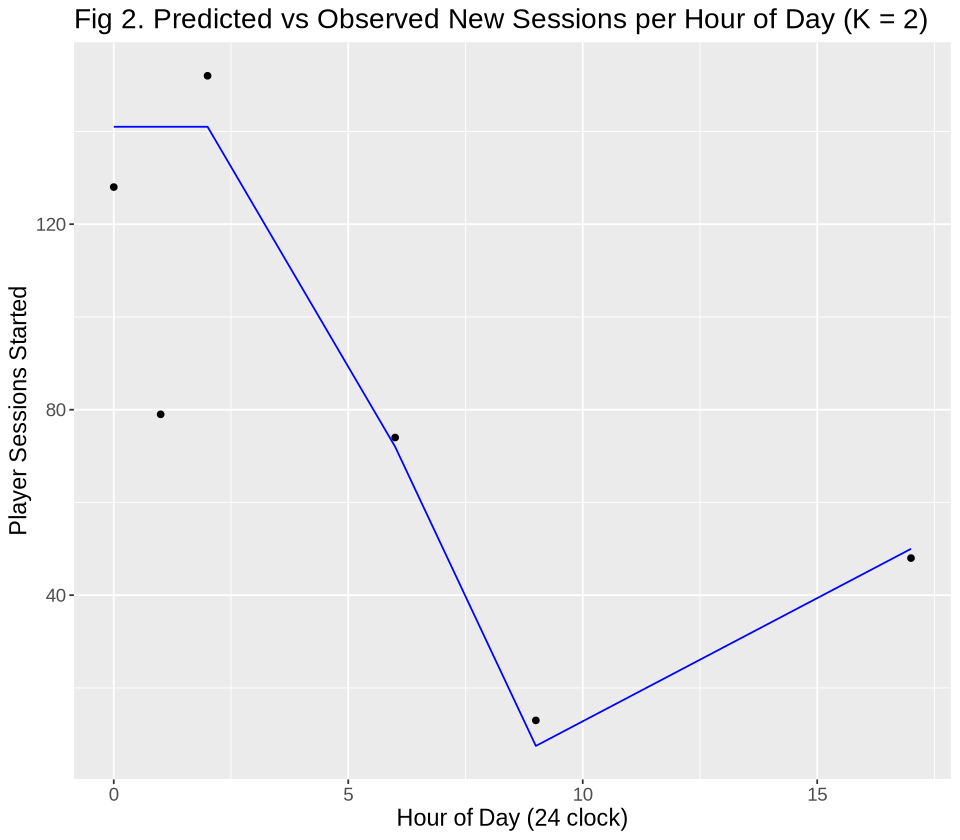

In [8]:
sessions_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = k_min) |>
    set_engine('kknn') |>
    set_mode('regression')

sessions_fit <- workflow() |>
    add_model(sessions_spec) |>
    add_recipe(sessions_recipe) |>
    fit(data = sessions_training)

sessions_predict <- sessions_fit |>
    predict(sessions_testing) |>
    bind_cols(sessions_testing)

sessions_plot_pred <- sessions_predict |>
    ggplot(aes(x = start_hour, y = player_count)) +
    geom_point() + geom_line(aes(y = .pred), color = 'blue') +
    labs(x = 'Hour of Day (24 clock)', y = 'Player Sessions Started', 
         title = 'Fig 2. Predicted vs Observed New Sessions per Hour of Day (K = 2)') + 
    theme(text = element_text(size = 14)) 
sessions_plot_pred

In [9]:
sessions_max <- sessions_predict |>
    slice_max(player_count, n = 1) |>
    select(start_hour) |>
    pull()
sessions_max

[1] 2

In [10]:
rmse <- sessions_workflow |>
    slice_min(mean, n = 1) |> 
    select(mean) |>
    pull()
rmse

rmspe <- sessions_predict |>
    metrics(truth = player_count, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
rmspe

[1] 21.31746

[1] 26.36996

In [11]:
min(new_sessions_count)
max(new_sessions_count)

[1] 0

[1] 152